In [1]:
#basic python packages
import numpy as np
%matplotlib notebook 
import pylab as plt

#for nice progression bars in loops
from tqdm import tqdm

#network analysis package
import networkx as nx

#quantum graph package
from NAQ_graphs import NAQ



In [2]:
#choose parameters:
Xi=2.76
gam=0.41
r_min=0.4
r_0=0.9

#daughter node radii:
#r_1=alpha*r_p
#r_2=beta*r_p

#r_p=(r_1)**Xi+(r_2)**Xi
#gam=(r_2/r_1)**2

#calculating alpha/beta:
g=np.sqrt(gam)
alpha=(1+(g**Xi))**(-1/Xi)
beta=g*alpha
alpha=0.85
beta=0.85
print(alpha,beta)

#building artery network
inp=nx.empty_graph()
inp.add_node(0,pos=(0,0))

parent_node=0
r_p=r_0
        
RA={}
RA[0]=r_0
Pos_A={}
Pos_A[0]=(0,0)


LA={}

Q=[]
Q.append(0)

while len(Q)>0:
    x=Q.pop(0)
    r_p=RA[x]
    
    #calc daughter radii
    r_1=alpha*r_p
    r_2=beta*r_p
    
    if r_1>0.005:    
        a_length=15.75*(r_1**1.1)
    else:
        a_length=1.79*(r_1**0.47)
        
    if r_2>0.005:    
        b_length=15.75*(r_1**1.1)
    else:
        b_length=1.79*(r_1**0.47)

    #give birth
    #alpha daughter
    al=(x*2)+1
    Pos_A[al]=(Pos_A[x][0]+(a_length*(np.sin((7*np.pi)/18))),Pos_A[x][1]+(a_length*(np.sin(np.pi/9))))
    inp.add_node(al,pos=Pos_A[al])
    inp.add_edge(al,x,length=a_length)
    RA[al]=r_1
    LA[al]=a_length
    
    #beta daughter
    bet=(x+1)*2
    Pos_A[bet]=(Pos_A[x][0]+(b_length*(np.sin((7*np.pi)/18))),Pos_A[x][1]-(b_length*(np.sin(np.pi/9))))
    inp.add_node(bet,pos=Pos_A[bet])
    inp.add_edge(bet,x,length=b_length)
    RA[bet]=r_2
    LA[bet]=b_length
    
    if r_1>r_min:
        Q.append(al)
        
    if r_2>r_min:
        Q.append(bet)
        
#nx.draw(inp,with_labels=True,pos=Pos_A)
  
mapping={}
new_pos={}
for i in inp.nodes():
    if inp.degree(i)>1:
        mapping[i]=i+50000
        new_pos[i+50000]=Pos_A[i]
    else:
        new_pos[i]=Pos_A[i]
    
    
new_inp=nx.relabel_nodes(inp,mapping,new_pos)

#-----------------------------------------------------------------------------------------------------------------------
#building Venous network
outp=nx.empty_graph()
outp.add_node(0,pos=(50,0))

parent_node=0
r_p=r_0
        
RV={}
RV[0]=r_0
Pos_V={}
Pos_V[0]=(60,0)

LV={}

Q=[]
Q.append(0)

while len(Q)>0:
    x=Q.pop(0)
    r_p=RV[x]
    
    #calc daughter radii
    r_1=alpha*r_p
    r_2=beta*r_p
    
    if r_1>=0.2:    
        v_length=14.54*r_1
    if r_2>=0.2:    
        v_length=14.54*r_2
    
    #give birth
    #alpha daughter
    al=(x*2)+1
    Pos_V[al]=(Pos_V[x][0]-(v_length*(np.sin((7*np.pi)/18))),Pos_V[x][1]+(v_length*(np.sin(np.pi/9))))
    outp.add_node(al,pos=Pos_V[al])
    outp.add_edge(al,x,length=v_length)
    RV[al]=r_1
    LV[al]=v_length
    
    #beta daughter
    bet=(x+1)*2
    Pos_V[bet]=(Pos_V[x][0]-(v_length*(np.sin((7*np.pi)/18))),Pos_V[x][1]-(v_length*(np.sin(np.pi/9))))
    outp.add_node(bet,pos=Pos_V[bet])
    outp.add_edge(bet,x,length=v_length)
    RV[bet]=r_2
    LV[bet]=v_length

    if r_1>r_min:
        Q.append(al)
        
    if r_2>r_min:
        Q.append(bet)
        
#nx.draw(outp,with_labels=True,pos=Pos_V)

for i in outp.nodes():
    if i in new_pos:
       p=i
    else:
        new_pos[i]=Pos_V[i]
        
G=nx.compose(new_inp,outp)
G.add_node('I', pos = (-10,0))                     #input
G.add_edge('I',50000, length=1.)
G.add_node('O', pos = (70,0))                     #output
G.add_edge('O',0, length=1.)

new_pos['I']=(-10,0)
new_pos['O']=(70,0)


lengths = [G[i][j]['length'] for i,j in G.edges]
pos = [G.node[i]['pos'] for i in G]

G = nx.convert_node_labels_to_integers(G)

0.85 0.85


<IPython.core.display.Javascript object>


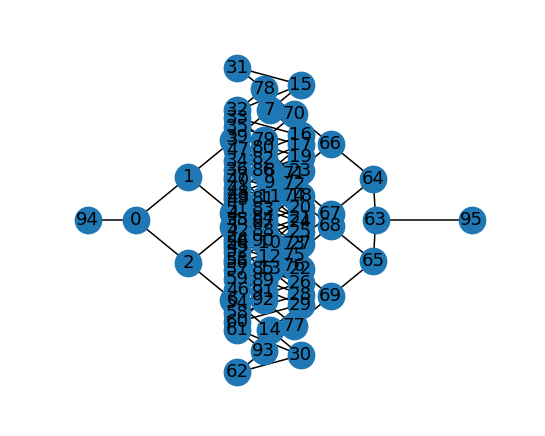

(-14.02458394694614,
 74.02458394694615,
 -15.550648882655572,
 15.550648882655576)

In [3]:

plt.figure(figsize=(5,4))
nx.draw_networkx(G,pos=pos)
plt.axis('off')



In [4]:
#additional parameters (do not modify)
chi = np.array([ 1.j for i in range(len(G.edges))])
group = 'U1'
transport_graph = True

#create the main object
naq_u1 = NAQ(G, lengths = lengths, chi = chi, group = group, transport_graph = transport_graph)

#set the inputs/outputs
naq_u1.input_nodes = [len(G)-1, ]  #which nodes are input nodes (list of nodes id)
naq_u1.input_values = [1., ]       #fix the input flux on all the nodes (list of number one per input_nodes)
naq_u1.output_nodes = [len(G)-2, ] #which nodes are output nodes (list of nodes id)

#set the wavenumber
k_0 = 0.233
naq_u1.update_chi(k_0) 


#after having setup the problem, we can solve it:
output_flux = naq_u1.test_laplacian()
print("Ouput flux: ", output_flux)

Ouput flux:  1.3398595019376138


<IPython.core.display.Javascript object>


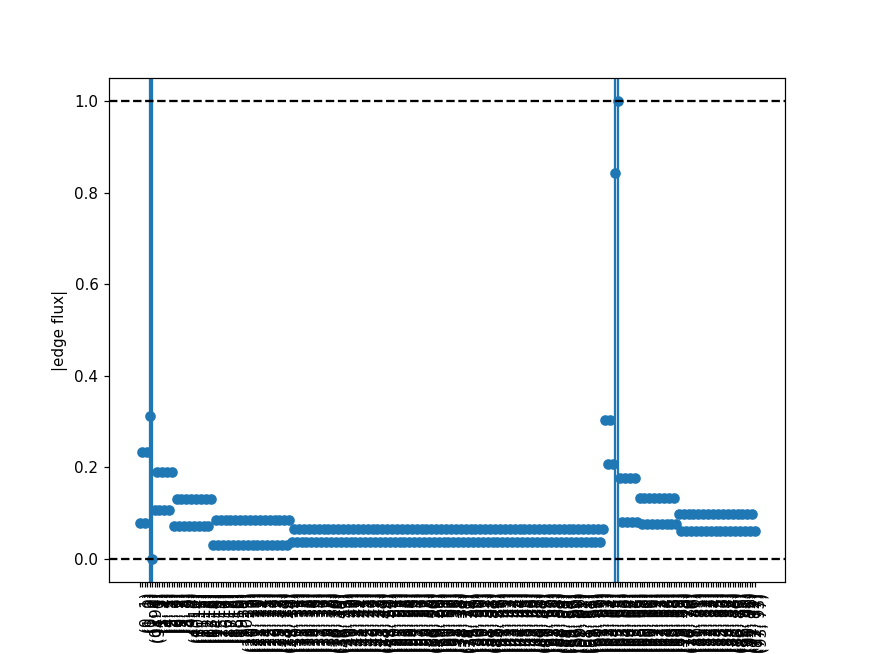

Text(0,0.5,'|edge flux|')

In [5]:
#then compute the solution on each node
sol = k_0*naq_u1.compute_solution()

#and convert it to each edge
flux = naq_u1.node_solution_to_edge_solution(sol)

#then plot it:
plt.figure(figsize=(8,6))
plt.plot(np.abs(flux),'o')

labels = [] #cpllect the edge ids for plotting
for ei, e in enumerate(list(naq_u1.graph.edges())):
        (u, v) = e[:2]
        labels.append(str((u,v)))
        labels.append(str((v,u)))

        #plot vertical lines for degree one edges
        if len(naq_u1.graph[v]) == 1:
            plt.axvline(2*ei)
            plt.axvline(2*ei+1)
                
#add x-labels     
ax = plt.gca()
ax.set_xticks(np.arange(2*len(G.edges())))
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

plt.axhline(0, c='k', ls='--')
plt.axhline(naq_u1.input_values[0], c='k', ls='--')
plt.xlabel('edge')
plt.ylabel('|edge flux|')

<IPython.core.display.Javascript object>


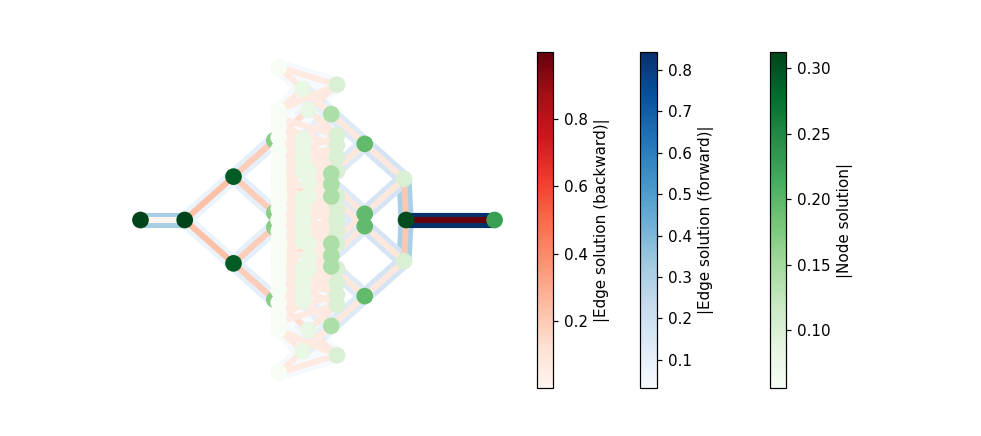

In [6]:
#plot the node and edge solution on the graph itself

#first set what to plot on nodes and edges (doubled, one for each direction)
node_solution = np.abs(sol)
edge_solution_for = np.abs(flux)[::2]
edge_solution_bac = np.abs(flux)[1::2]


plt.figure(figsize=(9,4))

nodes = nx.draw_networkx_nodes(G, pos=pos, node_color = node_solution ,cmap = 'Greens', node_size = 100)
edges_1 = nx.draw_networkx_edges(G, pos=pos, edge_color = edge_solution_for, edge_cmap = plt.get_cmap('Blues'), width = 10)
edges_2 = nx.draw_networkx_edges(G, pos=pos, edge_color = edge_solution_bac, edge_cmap = plt.get_cmap('Reds'), width = 4)
plt.axis('off')

plt.colorbar(nodes,label='|Node solution|')
plt.colorbar(edges_1, label='|Edge solution (forward)|')
plt.colorbar(edges_2, label='|Edge solution (backward)|')


In [7]:
#scan the spectrum k, with n_k wavenumbers from k_min to k_max

k_min = 0.01
k_max = 0.5
n_k = 1000


K = np.linspace(k_min, k_max, n_k)
s = np.zeros(len(K))

for i in tqdm(range(n_k)):
    naq_u1.update_chi(K[i]) #first update the wavenumber
    s[i] = K[i]*naq_u1.test_laplacian() #compute the output flux (we need to multiply by the wavenumber here)


100%|██████████| 1000/1000 [00:16<00:00, 60.68it/s]


<IPython.core.display.Javascript object>


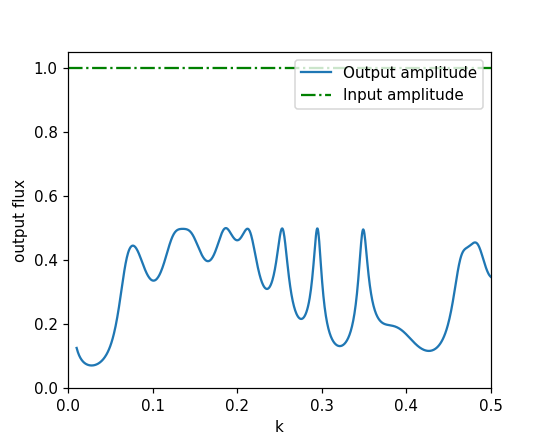

Text(0,0.5,'output flux')

In [21]:
#plot the spectrum
plt.figure(figsize=(5,4))
plt.plot(K,s, label='Output amplitude')
plt.axhline(np.sum(naq_u1.input_values), ls='-.', c='g', label='Input amplitude')

plt.axis([0,k_max,0,np.sum(naq_u1.input_values)+0.05])

plt.legend(loc='best')
plt.xlabel('k')
plt.ylabel('output flux')


<IPython.core.display.Javascript object>


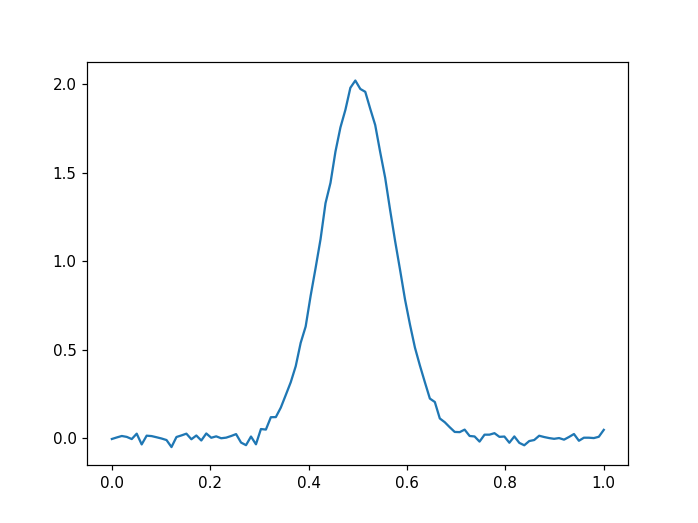

In [20]:
def test_function(t):
    a = 2
    t_0=0.5
    sig = 0.1
    return a*np.exp(-(t-t_0)**2/sig**2)# + np.random.normal(0,0.1)

n_T = 100
T = np.linspace(0,1, n_T)
signal =  test_function(T)+np.random.normal(0,0.02,len(X))

plt.figure()
plt.plot(T,signal)

In [ ]:
# fft of signal
#fft(signal)(omega)
omega = np.fft.fftfreq
c = 1
omega = c*k

convolved_signal = fft(signal)*s

fft_inverse(convolved_signal)